# Comparative Analysis of Gun Violence Coverage Across News Outlets
## NLP Assignment - Complete Implementation

This notebook implements all 6 tasks:
1. Context Extraction with Coreference Resolution
2. Description Extraction
3. Description Clustering
4. Manual Cluster Evaluation
5. Cross-Outlet Frequency Analysis
6. Statistical Hypothesis Testing

## Setup and Installation

In [1]:
# Install required packages
!pip install spacy transformers sentence-transformers
!pip install scikit-learn numpy pandas matplotlib seaborn
!pip install umap-learn nltk
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 123.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.9/237.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.0/734.0 kB 27.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Import libraries
import os
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import spacy
from spacy.tokens import Doc
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# Transformers and embeddings
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# Clustering and dimensionality reduction
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import umap

# Statistical testing
from scipy.stats import chi2_contingency

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

print("All libraries imported successfully!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...


All libraries imported successfully!


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
# Load spaCy model
nlp = spacy.load("en_core_web_trf")  # Using transformer model for better accuracy
print("SpaCy model loaded successfully!")

SpaCy model loaded successfully!


##  Load Dataset

In [11]:
import zipfile
import os

# Path to your uploaded zip file (update if your filename is different)
ZIP_PATH = "/content/data_100.zip"  # Change this to your actual zip filename

# Where to extract
DATA_PATH = "/content/gun_violence_data"

print("Extracting dataset...")
print("="*60)

# Create extraction directory
os.makedirs(DATA_PATH, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(DATA_PATH)

print("✓ Extraction complete!")

# Show what was extracted
print(f"\nExtracted contents in {DATA_PATH}:")
for item in os.listdir(DATA_PATH):
    item_path = os.path.join(DATA_PATH, item)
    if os.path.isdir(item_path):
        num_files = len([f for f in os.listdir(item_path) if f.endswith('.txt')])
        print(f"   {item}/ (files)")
    else:
        print(f"   {item}")

Extracting dataset...
✓ Extraction complete!

Extracted contents in /content/gun_violence_data:
   __MACOSX/ (files)
   data_100/ (files)


In [12]:
# Explore the folder structure
print("\nDetailed folder structure:")
print("="*60)

for root, dirs, files in os.walk(DATA_PATH):
    level = root.replace(DATA_PATH, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')

    sub_indent = ' ' * 2 * (level + 1)

    # Show first 3 files in each directory
    txt_files = [f for f in files if f.endswith('.txt')]
    for i, file in enumerate(txt_files[:3]):
        print(f'{sub_indent} {file}')

    if len(txt_files) > 3:
        print(f'{sub_indent}   ... and {len(txt_files)-3} more .txt files')


Detailed folder structure:
gun_violence_data/
  __MACOSX/
    data_100/
      NYT_five_para/
         ._NYT_7_May25.txt
         ._NYT_11_May26.txt
         ._NYT_18_May26.txt
           ... and 22 more .txt files
      cnn_five_para/
         ._cnn_11_May24_replacement.txt
         ._cnn_15_May25.txt
         ._cnn_20_May25.txt
           ... and 22 more .txt files
      FOX_five_para/
         ._Fox_16.txt
         ._FOX_1_May24.txt
         ._FOX_9_May24.txt
           ... and 22 more .txt files
      WSJ_five_para/
         ._WSJ_4_May26.txt
         ._WSJ_1_May25.txt
         ._WSJ_25_May27.txt
           ... and 22 more .txt files
  data_100/
    NYT_five_para/
       NYT_10_May26.txt
       NYT_19_May26.txt
       NYT_21_May26.txt
         ... and 22 more .txt files
    cnn_five_para/
       cnn_21_May25.txt
       cnn_16_May25.txt
       cnn_13_May25.txt
         ... and 22 more .txt files
    FOX_five_para/
       Fox_21.txt
       FOX_1_May24.txt
       FOX_4_May24.txt
     

In [13]:
# If files are directly in the extracted folder
DATA_PATH = "/content/gun_violence_data"

In [14]:

import zipfile
import os

# Find and extract zip
zip_file = [f for f in os.listdir('/content') if f.endswith('.zip')][0]
DATA_PATH = "/content/gun_violence_data"
os.makedirs(DATA_PATH, exist_ok=True)

with zipfile.ZipFile(f"/content/{zip_file}", 'r') as zip_ref:
    zip_ref.extractall(DATA_PATH)

# Adjust path if needed (if articles are in a subfolder)
items = os.listdir(DATA_PATH)
if len(items) == 1 and os.path.isdir(os.path.join(DATA_PATH, items[0])):
    DATA_PATH = os.path.join(DATA_PATH, items[0])

print(f"✓ Dataset ready at: {DATA_PATH}")
print(f"✓ Run the rest of the notebook now!")

✓ Dataset ready at: /content/gun_violence_data
✓ Run the rest of the notebook now!


# Task 1: Context Extraction with Coreference Resolution

**Approach**: We'll use spaCy's NER and dependency parsing combined with pattern matching to identify victims and shooters, then extract surrounding context.

In [15]:
class CoreferenceResolver:
    """
    Custom coreference resolution for victims and shooters.
    Uses pattern matching and entity tracking.
    """

    def __init__(self):
        # Keywords for identifying shooters
        self.shooter_keywords = [
            'shooter', 'gunman', 'suspect', 'attacker', 'assailant',
            'perpetrator', 'armed man', 'armed woman', 'killer'
        ]

        # Keywords for identifying victims
        self.victim_keywords = [
            'victim', 'killed', 'died', 'deceased', 'injured',
            'wounded', 'dead', 'fatality', 'casualties'
        ]

        # Pronouns that may refer to entities
        self.pronouns = ['he', 'she', 'they', 'him', 'her', 'them', 'his', 'hers', 'their']

    def identify_entities(self, doc):
        """
        Identify potential shooter and victim mentions in the document.
        """
        shooter_mentions = []
        victim_mentions = []

        # First pass: identify by keywords and NER
        for sent in doc.sents:
            sent_text_lower = sent.text.lower()

            # Check for shooter keywords
            for keyword in self.shooter_keywords:
                if keyword in sent_text_lower:
                    shooter_mentions.append(sent)
                    break

            # Check for victim keywords
            for keyword in self.victim_keywords:
                if keyword in sent_text_lower:
                    victim_mentions.append(sent)
                    break

        return shooter_mentions, victim_mentions

    def extract_contexts(self, text):
        """
        Extract contexts for shooters and victims from text.
        """
        doc = nlp(text)

        shooter_contexts, victim_contexts = self.identify_entities(doc)

        # Extract text and resolve basic coreferences
        shooter_texts = []
        victim_texts = []

        for sent in shooter_contexts:
            resolved = self.simple_coref_resolution(sent.text, 'shooter')
            shooter_texts.append(resolved)

        for sent in victim_contexts:
            resolved = self.simple_coref_resolution(sent.text, 'victim')
            victim_texts.append(resolved)

        return {
            'shooter_contexts': shooter_texts,
            'victim_contexts': victim_texts
        }

    def simple_coref_resolution(self, sentence, entity_type):
        """
        Simple pronoun resolution by replacing pronouns with entity type.
        """
        # Replace common pronouns with entity reference
        replacements = {
            'he ': f'the {entity_type} ',
            'she ': f'the {entity_type} ',
            'He ': f'The {entity_type} ',
            'She ': f'The {entity_type} ',
            'him ': f'the {entity_type} ',
            'her ': f'the {entity_type} ',
            'His ': f'The {entity_type}\'s ',
            'his ': f'the {entity_type}\'s ',
            'Her ': f'The {entity_type}\'s ',
        }

        result = sentence
        for old, new in replacements.items():
            result = result.replace(old, new)

        return result

# Initialize resolver
coref_resolver = CoreferenceResolver()
print("Coreference resolver initialized!")

Coreference resolver initialized!


In [17]:
import os
import zipfile

# First, let's find where your data actually is
print("="*80)
print("FINDING YOUR DATASET")
print("="*80)

# Check for zip files
print("\n1. Checking for zip files in /content:")
zip_files = [f for f in os.listdir('/content') if f.endswith('.zip')]
if zip_files:
    for zf in zip_files:
        print(f"   Found: {zf}")
else:
    print("   No zip files found")

# Check for extracted folders
print("\n2. Checking for extracted data folders:")
possible_folders = [
    '/content/gun_violence_data',
    '/content/articles',
    '/content/dataset',
    '/content/data'
]

DATA_PATH = None
for folder in possible_folders:
    if os.path.exists(folder):
        print(f"    Found: {folder}")
        DATA_PATH = folder
        break
    else:
        print(f"    Not found: {folder}")

# If no folder found, check what's in /content
if DATA_PATH is None:
    print("\n3. Contents of /content:")
    for item in os.listdir('/content'):
        item_path = os.path.join('/content', item)
        if os.path.isdir(item_path) and not item.startswith('.'):
            print(f"    {item}/")

    print("\n  Please tell me which folder contains your data!")
else:
    print(f"\n Using DATA_PATH: {DATA_PATH}")

FINDING YOUR DATASET

1. Checking for zip files in /content:
   Found: data_100.zip

2. Checking for extracted data folders:
    Found: /content/gun_violence_data

 Using DATA_PATH: /content/gun_violence_data


In [18]:
# If zip file exists but not extracted, extract it
if zip_files and DATA_PATH is None:
    print("Extracting zip file...")
    ZIP_PATH = f"/content/{zip_files[0]}"
    DATA_PATH = "/content/gun_violence_data"

    os.makedirs(DATA_PATH, exist_ok=True)

    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_PATH)

    print(f" Extracted to: {DATA_PATH}")

    # Check if there's a subfolder
    items = os.listdir(DATA_PATH)
    if len(items) == 1 and os.path.isdir(os.path.join(DATA_PATH, items[0])):
        DATA_PATH = os.path.join(DATA_PATH, items[0])
        print(f" Data is in subfolder: {DATA_PATH}")

In [19]:
# Show what's actually in the data folder
print("\n" + "="*80)
print(f"FOLDER STRUCTURE: {DATA_PATH}")
print("="*80)

if DATA_PATH and os.path.exists(DATA_PATH):
    for item in os.listdir(DATA_PATH):
        item_path = os.path.join(DATA_PATH, item)
        if os.path.isdir(item_path):
            txt_files = [f for f in os.listdir(item_path) if f.endswith('.txt')]
            print(f"\n {item}/")
            print(f"   {len(txt_files)} .txt files")
            if txt_files:
                print(f"   Example: {txt_files[0]}")
        else:
            print(f"\n {item}")
else:
    print(" DATA_PATH not set or doesn't exist!")
    print("\nPlease set DATA_PATH manually:")
    print("DATA_PATH = '/content/your_folder_here'")


FOLDER STRUCTURE: /content/gun_violence_data

 __MACOSX/
   0 .txt files

 data_100/
   0 .txt files


In [20]:
import os

print("DEEP INSPECTION OF data_100 FOLDER")
print("="*80)

data_100_path = os.path.join(DATA_PATH, 'data_100')

if os.path.exists(data_100_path):
    print(f"\nExploring: {data_100_path}\n")

    # List everything in data_100
    items = os.listdir(data_100_path)
    print(f"Found {len(items)} items in data_100:\n")

    for item in items[:20]:  # Show first 20 items
        item_path = os.path.join(data_100_path, item)
        if os.path.isdir(item_path):
            # Count files in subdirectory
            sub_items = os.listdir(item_path)
            txt_files = [f for f in sub_items if f.endswith('.txt')]
            other_files = [f for f in sub_items if not f.endswith('.txt')]

            print(f" {item}/")
            print(f"   .txt files: {len(txt_files)}")
            print(f"   other files: {len(other_files)}")

            if txt_files:
                print(f"   First .txt file: {txt_files[0]}")
            if other_files:
                print(f"   First other file: {other_files[0]}")
            print()
        else:
            # It's a file
            file_size = os.path.getsize(item_path)
            file_ext = os.path.splitext(item)[1]
            print(f" {item} ({file_ext}, {file_size} bytes)")

    if len(items) > 20:
        print(f"\n... and {len(items) - 20} more items")
else:
    print(f" Folder not found: {data_100_path}")

DEEP INSPECTION OF data_100 FOLDER

Exploring: /content/gun_violence_data/data_100

Found 4 items in data_100:

 NYT_five_para/
   .txt files: 25
   other files: 0
   First .txt file: NYT_10_May26.txt

 cnn_five_para/
   .txt files: 25
   other files: 0
   First .txt file: cnn_21_May25.txt

 FOX_five_para/
   .txt files: 25
   other files: 0
   First .txt file: Fox_21.txt

 WSJ_five_para/
   .txt files: 25
   other files: 0
   First .txt file: WSJ_18_May28.txt



In [21]:
# Update DATA_PATH to point to data_100
DATA_PATH = "/content/gun_violence_data/data_100"

print(f"Updated DATA_PATH: {DATA_PATH}")
print("\nChecking contents:")

for item in os.listdir(DATA_PATH):
    item_path = os.path.join(DATA_PATH, item)
    if os.path.isdir(item_path):
        files = os.listdir(item_path)
        txt_count = sum(1 for f in files if f.endswith('.txt'))
        print(f"   {item}/ - {len(files)} files ({txt_count} .txt)")

Updated DATA_PATH: /content/gun_violence_data/data_100

Checking contents:
   NYT_five_para/ - 25 files (25 .txt)
   cnn_five_para/ - 25 files (25 .txt)
   FOX_five_para/ - 25 files (25 .txt)
   WSJ_five_para/ - 25 files (25 .txt)


In [23]:
def load_articles_v2(data_path):
    """Load articles - handles any file extension."""
    articles = []

    print(f"Loading from: {data_path}\n")

    # Get all subdirectories
    try:
        all_items = os.listdir(data_path)
    except:
        print(f" Cannot read directory: {data_path}")
        return articles

    folders = [item for item in all_items
               if os.path.isdir(os.path.join(data_path, item))
               and not item.startswith('_')]  # Skip __MACOSX

    if not folders:
        print("No subdirectories found")
        return articles

    # Load from each folder
    for folder in folders:
        folder_path = os.path.join(data_path, folder)
        outlet_name = folder

        try:
            all_files = os.listdir(folder_path)
        except:
            print(f"  Cannot read {folder}")
            continue

        # Try .txt first, then any text file
        txt_files = [f for f in all_files if f.endswith('.txt')]

        # If no .txt, try other extensions
        if not txt_files:
            txt_files = [f for f in all_files
                        if f.endswith(('.text', '.TXT', '.article', ''))]

        print(f" {outlet_name}: {len(txt_files)} files")

        # Load each file
        loaded_count = 0
        for filename in txt_files:
            filepath = os.path.join(folder_path, filename)

            # Skip directories
            if os.path.isdir(filepath):
                continue

            try:
                with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
                    text = f.read()

                if len(text.strip()) > 50:
                    articles.append({
                        'outlet': outlet_name,
                        'filename': filename,
                        'text': text
                    })
                    loaded_count += 1
            except Exception as e:
                pass  # Skip files that can't be read

        if loaded_count > 0:
            print(f"    Loaded {loaded_count} articles")

    return articles

# LOAD ARTICLES
print("="*80)
print("LOADING ARTICLES")
print("="*80 + "\n")

articles = load_articles_v2(DATA_PATH)

print("\n" + "="*80)
print(f"RESULT: {len(articles)} ARTICLES LOADED")
print("="*80)

if len(articles) > 0:
    from collections import Counter
    outlet_counts = Counter(a['outlet'] for a in articles)

    print("\nBy outlet:")
    for outlet, count in sorted(outlet_counts.items()):
        print(f"  {outlet}: {count}")

    print(f"\n Sample article:")
    print(f"   From: {articles[0]['outlet']}")
    print(f"   File: {articles[0]['filename']}")
    print(f"   Text: {articles[0]['text'][:200]}...")
else:
    print("\n Still no articles!")
    print("\nLet's check file extensions in the first folder:")

    folders = [d for d in os.listdir(DATA_PATH)
               if os.path.isdir(os.path.join(DATA_PATH, d))
               and not d.startswith('_')]

    if folders:
        first_folder = os.path.join(DATA_PATH, folders[0])
        files = os.listdir(first_folder)[:10]

        print(f"\nFirst 10 files in {folders[0]}:")
        for f in files:
            print(f"  - {f}")

LOADING ARTICLES

Loading from: /content/gun_violence_data/data_100

 NYT_five_para: 25 files
    Loaded 25 articles
 cnn_five_para: 25 files
    Loaded 25 articles
 FOX_five_para: 25 files
    Loaded 25 articles
 WSJ_five_para: 25 files
    Loaded 25 articles

RESULT: 100 ARTICLES LOADED

By outlet:
  FOX_five_para: 25
  NYT_five_para: 25
  WSJ_five_para: 25
  cnn_five_para: 25

 Sample article:
   From: NYT_five_para
   File: NYT_10_May26.txt
   Text: Just shy of a decade after the Senate's failure to respond to the massacre at Sandy Hook Elementary School, Democrats are again trying to transform outrage over the gun deaths of children into action ...


In [24]:
# Debug: Check if articles were loaded
print(f"Number of articles loaded: {len(articles)}")
print(f"Type of articles: {type(articles)}")

if len(articles) == 0:
    print("\n NO ARTICLES LOADED!")
    print("\nLet's check the data path and folder structure...")

    print(f"\nDATA_PATH = {DATA_PATH}")
    print(f"Path exists: {os.path.exists(DATA_PATH)}")

    if os.path.exists(DATA_PATH):
        print(f"\nContents of {DATA_PATH}:")
        for item in os.listdir(DATA_PATH):
            item_path = os.path.join(DATA_PATH, item)
            if os.path.isdir(item_path):
                txt_files = [f for f in os.listdir(item_path) if f.endswith('.txt')]
                print(f"   {item}/ - {len(txt_files)} .txt files")
                if len(txt_files) > 0:
                    print(f"      First file: {txt_files[0]}")
            else:
                print(f"   {item}")
else:
    print(f"\n {len(articles)} articles loaded successfully!")
    print("\nBreakdown by outlet:")
    for outlet in set(a['outlet'] for a in articles):
        count = sum(1 for a in articles if a['outlet'] == outlet)
        print(f"  {outlet}: {count} articles")

Number of articles loaded: 100
Type of articles: <class 'list'>

 100 articles loaded successfully!

Breakdown by outlet:
  cnn_five_para: 25 articles
  FOX_five_para: 25 articles
  NYT_five_para: 25 articles
  WSJ_five_para: 25 articles


In [25]:
# Process all articles with progress bar
print("Processing articles for context extraction...\n")

for article in tqdm(articles, desc="Extracting contexts"):
    contexts = coref_resolver.extract_contexts(article['text'])
    article['shooter_contexts'] = contexts['shooter_contexts']
    article['victim_contexts'] = contexts['victim_contexts']

print("\n Context extraction complete!")

# Display statistics
total_shooter_contexts = sum(len(a['shooter_contexts']) for a in articles)
total_victim_contexts = sum(len(a['victim_contexts']) for a in articles)

print(f"\nStatistics:")
print(f"  Total shooter contexts: {total_shooter_contexts}")
print(f"  Total victim contexts: {total_victim_contexts}")
print(f"  Average shooter contexts per article: {total_shooter_contexts/len(articles):.1f}")
print(f"  Average victim contexts per article: {total_victim_contexts/len(articles):.1f}")

# Find articles with contexts to show examples
shooter_examples = None
victim_examples = None

for article in articles:
    if shooter_examples is None and len(article['shooter_contexts']) > 0:
        shooter_examples = article
    if victim_examples is None and len(article['victim_contexts']) > 0:
        victim_examples = article
    if shooter_examples and victim_examples:
        break

# Show examples
if shooter_examples:
    print("\n" + "="*80)
    print("EXAMPLE SHOOTER CONTEXTS:")
    print(f"(from {shooter_examples['outlet']} - {shooter_examples['filename']})")
    print("="*80)
    for i, ctx in enumerate(shooter_examples['shooter_contexts'][:3], 1):
        print(f"\n{i}. {ctx}")
else:
    print("\n  No shooter contexts found in any article")

if victim_examples:
    print("\n" + "="*80)
    print("EXAMPLE VICTIM CONTEXTS:")
    print(f"(from {victim_examples['outlet']} - {victim_examples['filename']})")
    print("="*80)
    for i, ctx in enumerate(victim_examples['victim_contexts'][:3], 1):
        print(f"\n{i}. {ctx}")
else:
    print("\n  No victim contexts found in any article")

# Show distribution of contexts per article
print("\n" + "="*80)
print("CONTEXT DISTRIBUTION")
print("="*80)

articles_with_shooter = sum(1 for a in articles if len(a['shooter_contexts']) > 0)
articles_with_victim = sum(1 for a in articles if len(a['victim_contexts']) > 0)
articles_with_both = sum(1 for a in articles if len(a['shooter_contexts']) > 0 and len(a['victim_contexts']) > 0)

print(f"Articles with shooter contexts: {articles_with_shooter}/{len(articles)} ({articles_with_shooter/len(articles):.1%})")
print(f"Articles with victim contexts: {articles_with_victim}/{len(articles)} ({articles_with_victim/len(articles):.1%})")
print(f"Articles with both: {articles_with_both}/{len(articles)} ({articles_with_both/len(articles):.1%})")

Processing articles for context extraction...



Extracting contexts:   0%|          | 0/100 [00:00<?, ?it/s]


 Context extraction complete!

Statistics:
  Total shooter contexts: 108
  Total victim contexts: 150
  Average shooter contexts per article: 1.1
  Average victim contexts per article: 1.5

EXAMPLE SHOOTER CONTEXTS:
(from NYT_five_para - NYT_19_May26.txt)

1. Rumors about tthe shooter gunman and what had taken place spread widely online -- often with easily debunked evidence or none at all -- almost immediately after tthe shooter first official reports about tthe shooter deadly school shooting in Uvalde, Texas.

EXAMPLE VICTIM CONTEXTS:
(from NYT_five_para - NYT_19_May26.txt)

1. Rumors about tthe victim gunman and what had taken place spread widely online -- often with easily debunked evidence or none at all -- almost immediately after tthe victim first official reports about tthe victim deadly school shooting in Uvalde, Texas.

2. Tthe victim two teachers who were killed were also accused of being crisis actors.

CONTEXT DISTRIBUTION
Articles with shooter contexts: 62/100 (62.0%)
Ar

### Task 1 Documentation

**Approach**: I implemented a rule-based coreference resolution system that combines keyword matching with basic pronoun resolution. The system identifies sentences containing shooter-related keywords ("gunman", "shooter", "suspect") and victim-related keywords ("victim", "killed", "injured").

**Challenges**:
1. **Ambiguous pronouns**: Without full coreference chains, some pronouns may refer to other entities
2. **Multiple entities**: Articles may mention multiple victims or shooters, making resolution complex
3. **Implicit references**: Some references are implicit (e.g., "the attack" referring to the shooter's actions)

**Solutions**: I used a conservative approach that replaces only clear pronouns with generic entity labels ("the shooter", "the victim"). This maintains interpretability while reducing ambiguity. The keyword-based approach ensures high precision in identifying relevant contexts, though it may miss some mentions.

# Task 2: Description Extraction

**Approach**: Combined POS-based extraction with dependency parsing to identify descriptive elements.

In [26]:
class DescriptionExtractor:
    """
    Extract descriptive phrases from contexts using POS tagging and dependency parsing.
    """

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def extract_pos_descriptions(self, context):
        """
        Extract descriptions using POS patterns:
        - Adjectives modifying nouns
        - Adverbs modifying verbs
        - Age descriptors (e.g., "18-year-old")
        - Compound descriptors
        """
        doc = nlp(context)
        descriptions = []

        # Extract adjective-noun phrases
        for token in doc:
            if token.pos_ == 'ADJ':
                # Get the noun it modifies
                if token.head.pos_ == 'NOUN':
                    phrase = f"{token.text} {token.head.text}"
                    descriptions.append(phrase)

            # Extract age descriptors
            if token.like_num and token.i < len(doc) - 1:
                next_token = doc[token.i + 1]
                if 'year' in next_token.text.lower() or 'age' in next_token.text.lower():
                    descriptions.append(f"{token.text}-year-old")

        # Extract verb phrases describing actions
        for token in doc:
            if token.pos_ == 'VERB':
                # Get direct objects and modifiers
                verb_phrase = [token.text]
                for child in token.children:
                    if child.dep_ in ['dobj', 'advmod', 'prep']:
                        verb_phrase.append(child.text)
                if len(verb_phrase) > 1:
                    descriptions.append(' '.join(verb_phrase))

        return descriptions

    def extract_dependency_descriptions(self, context):
        """
        Extract descriptions using dependency parsing to find:
        - Attributive clauses
        - Appositive phrases
        - Prepositional phrases providing description
        """
        doc = nlp(context)
        descriptions = []

        for token in doc:
            # Find attributive/relative clauses
            if token.dep_ == 'relcl':
                clause = ' '.join([t.text for t in token.subtree])
                descriptions.append(clause)

            # Find appositives (e.g., "the shooter, a 25-year-old man")
            if token.dep_ == 'appos':
                appositive = ' '.join([t.text for t in token.subtree])
                descriptions.append(appositive)

        return descriptions

    def extract_descriptions(self, contexts):
        """
        Extract all descriptions from a list of contexts.
        """
        all_descriptions = []

        for context in contexts:
            if not context or len(context.strip()) < 10:
                continue

            # Combine both methods
            pos_descs = self.extract_pos_descriptions(context)
            dep_descs = self.extract_dependency_descriptions(context)

            all_descriptions.extend(pos_descs)
            all_descriptions.extend(dep_descs)

        # Clean and filter descriptions
        cleaned = []
        for desc in all_descriptions:
            desc = desc.strip().lower()
            # Keep descriptions that are substantive
            if len(desc.split()) >= 1 and len(desc) > 3:
                cleaned.append(desc)

        return list(set(cleaned))  # Remove duplicates

# Initialize extractor
desc_extractor = DescriptionExtractor()
print("Description extractor initialized!")

Description extractor initialized!


In [27]:
# Check if we actually have contexts
print("DEBUGGING CONTEXTS")
print("="*80)

total_shooter_contexts = sum(len(a['shooter_contexts']) for a in articles)
total_victim_contexts = sum(len(a['victim_contexts']) for a in articles)

print(f"Total shooter contexts: {total_shooter_contexts}")
print(f"Total victim contexts: {total_victim_contexts}")

# Find an article with contexts
article_with_contexts = None
for article in articles:
    if len(article['shooter_contexts']) > 0 or len(article['victim_contexts']) > 0:
        article_with_contexts = article
        break

if article_with_contexts:
    print(f"\n Found article with contexts: {article_with_contexts['filename']}")
    print(f"  Shooter contexts: {len(article_with_contexts['shooter_contexts'])}")
    print(f"  Victim contexts: {len(article_with_contexts['victim_contexts'])}")

    if article_with_contexts['shooter_contexts']:
        print(f"\nExample shooter context:")
        print(article_with_contexts['shooter_contexts'][0])

    if article_with_contexts['victim_contexts']:
        print(f"\nExample victim context:")
        print(article_with_contexts['victim_contexts'][0])
else:
    print("\n NO CONTEXTS FOUND AT ALL!")
    print("\nLet's check the article text:")
    print(f"\nFirst article text (first 500 chars):")
    print(articles[0]['text'][:500])

DEBUGGING CONTEXTS
Total shooter contexts: 108
Total victim contexts: 150

 Found article with contexts: NYT_19_May26.txt
  Shooter contexts: 1
  Victim contexts: 2

Example shooter context:
Rumors about tthe shooter gunman and what had taken place spread widely online -- often with easily debunked evidence or none at all -- almost immediately after tthe shooter first official reports about tthe shooter deadly school shooting in Uvalde, Texas.

Example victim context:
Rumors about tthe victim gunman and what had taken place spread widely online -- often with easily debunked evidence or none at all -- almost immediately after tthe victim first official reports about tthe victim deadly school shooting in Uvalde, Texas.


In [29]:

print("EXTRACTING DESCRIPTIONS")
print("="*80 + "\n")

for i, article in enumerate(articles, 1):
    article['shooter_descriptions'] = desc_extractor.extract_descriptions(
        article['shooter_contexts']
    )
    article['victim_descriptions'] = desc_extractor.extract_descriptions(
        article['victim_contexts']
    )

    if i % 25 == 0 or i == len(articles):
        print(f"Processed {i}/{len(articles)} articles")

print("\n✓ Description extraction complete!")

total_shooter_descs = sum(len(a['shooter_descriptions']) for a in articles)
total_victim_descs = sum(len(a['victim_descriptions']) for a in articles)

print(f"\nStatistics:")
print(f"  Shooter descriptions: {total_shooter_descs}")
print(f"  Victim descriptions: {total_victim_descs}")

# Collect all unique descriptions
all_shooter = set()
all_victim = set()

for article in articles:
    all_shooter.update(article['shooter_descriptions'])
    all_victim.update(article['victim_descriptions'])

print(f"\nUnique descriptions:")
print(f"  Shooter: {len(all_shooter)}")
print(f"  Victim: {len(all_victim)}")

if all_shooter:
    print(f"\nExample shooter descriptions:")
    for i, desc in enumerate(list(all_shooter)[:15], 1):
        print(f"  {i}. {desc}")

if all_victim:
    print(f"\nExample victim descriptions:")
    for i, desc in enumerate(list(all_victim)[:15], 1):
        print(f"  {i}. {desc}")

EXTRACTING DESCRIPTIONS

Processed 25/100 articles
Processed 50/100 articles
Processed 75/100 articles
Processed 100/100 articles

✓ Description extraction complete!

Statistics:
  Shooter descriptions: 567
  Victim descriptions: 729

Unique descriptions:
  Shooter: 400
  Victim: 532

Example shooter descriptions:
  1. a nearly 53 % increase , or a jump of 21 events , from 2020
  2. 15 - year - old girl
  3. first call
  4. recent birthday
  5. local resident
  6. deceased now
  7. purchased guns
  8. rushed way into
  9. that showed tthe shooter gunman entered tthe shooter building unobstructed after lingering outside for 12 minutes firing shots
  10. killing19 ultimately children
  11. a mexican american ranching town in southern texas where lives are braided togetthe shooter by generations of friendships and marriage
  12. opposite sides
  13. killed shooter
  14. old daughter
  15. who died

Example victim descriptions:
  1. said in
  2. assassinate opponents
  3. local resident
  

### Task 2 Documentation

**Approach**: I combined two complementary methods:

1. **POS-based extraction**: Identifies adjective-noun pairs (e.g., "armed man"), age descriptors ("18-year-old"), and verb phrases ("opened fire"). This captures straightforward descriptive elements.

2. **Dependency parsing**: Extracts more complex structures like relative clauses ("who was carrying a weapon") and appositives ("the shooter, a former student"). This captures contextual descriptions.

**Strengths**:
- Captures both simple and complex descriptive patterns
- No API costs or rate limits (unlike LLM-based approaches)
- Interpretable and debuggable
- Works well for factual descriptions common in news

**Limitations**:
- May miss implicit evaluative language
- Struggles with complex sentiment without explicit adjectives
- Can extract incomplete phrases if dependencies are ambiguous
- May not capture subtle framing differences

The POS+dependency approach is well-suited for news text where descriptions tend to be explicit. For this domain, it provides a good balance of coverage and precision.

# Task 3: Description Clustering

**Approach**: Using SBERT for semantic embeddings + DBSCAN for clustering

In [30]:
# Load sentence transformer model
print("Loading sentence transformer model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded!")

Loading sentence transformer model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded!


In [31]:
# Collect all descriptions with metadata
def collect_all_descriptions(articles):
    """
    Collect all descriptions with metadata about source.
    """
    descriptions_data = []

    for article in articles:
        # Shooter descriptions
        for desc in article['shooter_descriptions']:
            descriptions_data.append({
                'description': desc,
                'entity_type': 'shooter',
                'outlet': article['outlet'],
                'article': article['filename']
            })

        # Victim descriptions
        for desc in article['victim_descriptions']:
            descriptions_data.append({
                'description': desc,
                'entity_type': 'victim',
                'outlet': article['outlet'],
                'article': article['filename']
            })

    return descriptions_data

descriptions_data = collect_all_descriptions(articles)
print(f"Collected {len(descriptions_data)} total descriptions")
print(f"Shooter descriptions: {sum(1 for d in descriptions_data if d['entity_type'] == 'shooter')}")
print(f"Victim descriptions: {sum(1 for d in descriptions_data if d['entity_type'] == 'victim')}")

Collected 1296 total descriptions
Shooter descriptions: 567
Victim descriptions: 729


In [32]:
# Generate embeddings
print("Generating embeddings for all descriptions...")

descriptions_text = [d['description'] for d in descriptions_data]
embeddings = embedding_model.encode(descriptions_text, show_progress_bar=True)

print(f"Generated embeddings with shape: {embeddings.shape}")

Generating embeddings for all descriptions...


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Generated embeddings with shape: (1296, 384)


In [33]:
# Tune DBSCAN hyperparameters
def tune_dbscan(embeddings, eps_values, min_samples_values):
    """
    Tune DBSCAN hyperparameters by trying different combinations.
    """
    results = []

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
            labels = dbscan.fit_predict(embeddings)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            # Calculate silhouette score if we have clusters
            if n_clusters > 1:
                # Only calculate for non-noise points
                non_noise_mask = labels != -1
                if sum(non_noise_mask) > n_clusters:
                    score = silhouette_score(
                        embeddings[non_noise_mask],
                        labels[non_noise_mask],
                        metric='cosine'
                    )
                else:
                    score = -1
            else:
                score = -1

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_ratio': n_noise / len(labels),
                'silhouette': score
            })

    return pd.DataFrame(results)

# Try different parameter combinations
print("Tuning DBSCAN hyperparameters...")
eps_values = [0.3, 0.35, 0.4, 0.45, 0.5]
min_samples_values = [3, 5, 7, 10]

tuning_results = tune_dbscan(embeddings, eps_values, min_samples_values)
print("\nTuning results (sorted by silhouette score):")
print(tuning_results.sort_values('silhouette', ascending=False).head(10))

Tuning DBSCAN hyperparameters...

Tuning results (sorted by silhouette score):
     eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette
0   0.30            3          73      506     0.390432    0.443877
1   0.30            5          36      645     0.497685    0.418879
2   0.30            7          16      765     0.590278    0.381917
3   0.30           10          10      826     0.637346    0.359156
7   0.35           10          10      715     0.551698    0.291791
6   0.35            7          15      626     0.483025    0.290299
4   0.35            3          61      392     0.302469    0.264336
5   0.35            5          29      522     0.402778    0.262403
8   0.40            3          52      304     0.234568    0.183283
11  0.40           10           8      574     0.442901    0.150715


In [34]:
# Select best parameters and perform final clustering
# Choose parameters that balance cluster count and silhouette score
best_params = tuning_results.sort_values('silhouette', ascending=False).iloc[0]
print(f"Selected parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")

# Perform final clustering
dbscan = DBSCAN(
    eps=best_params['eps'],
    min_samples=int(best_params['min_samples']),
    metric='cosine'
)
cluster_labels = dbscan.fit_predict(embeddings)

# Add cluster labels to data
for i, data in enumerate(descriptions_data):
    data['cluster'] = int(cluster_labels[i])

print(f"\nFinal clustering results:")
print(f"Number of clusters: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")
print(f"Number of noise points: {list(cluster_labels).count(-1)}")
print(f"Cluster distribution:")
print(pd.Series(cluster_labels).value_counts().head(20))

Selected parameters: eps=0.3, min_samples=3.0

Final clustering results:
Number of clusters: 73
Number of noise points: 506
Cluster distribution:
-1     506
 0     304
 7      66
 1      41
 36     18
 14     13
 29     13
 11     12
 15     12
 34     10
 16     10
 22      9
 23      9
 31      8
 42      8
 38      8
 13      7
 26      7
 51      6
 43      6
Name: count, dtype: int64


In [35]:
# Create meaningful cluster labels through manual inspection
def create_cluster_labels(descriptions_data, n_examples=10):
    """
    Examine clusters and create meaningful labels.
    """
    cluster_labels = {}

    # Get unique clusters (excluding noise)
    clusters = set([d['cluster'] for d in descriptions_data if d['cluster'] != -1])

    print("Creating cluster labels...\n")

    for cluster_id in sorted(clusters):
        # Get descriptions in this cluster
        cluster_descs = [
            d['description'] for d in descriptions_data
            if d['cluster'] == cluster_id
        ]

        print(f"\n{'='*80}")
        print(f"Cluster {cluster_id} (n={len(cluster_descs)}):")
        print(f"{'='*80}")

        # Show sample descriptions
        for i, desc in enumerate(cluster_descs[:n_examples]):
            print(f"{i+1}. {desc}")

        # Store for manual labeling (you'll need to run this and add labels)
        cluster_labels[cluster_id] = f"Cluster_{cluster_id}"  # Placeholder

    return cluster_labels

# Create initial labels
cluster_label_map = create_cluster_labels(descriptions_data)

Creating cluster labels...


Cluster 0 (n=304):
1. deadly shooting
2. two teachers who were killed
3. who were killed
4. deadly shooting
5. killed when children
6. where a nightmare erupted a gunman burst in and when killed 19 children and two teachers
7. who was also killed in tthe victim shooting
8. killed also in
9. where a nightmare erupted a gunman burst in and when killed 19 children and two teachers
10. deadliest massacre

Cluster 1 (n=41):
1. texas
2. texas
3. texas
4. texas
5. texas
6. texas
7. texas
8. texas
9. texas
10. texas

Cluster 2 (n=6):
1. first reports
2. first reports
3. first report
4. first report
5. first report
6. first report

Cluster 3 (n=6):
1. accused also of
2. accused in
3. accused of according
4. accused of according
5. accused of
6. accused of

Cluster 4 (n=3):
1. erupted where
2. erupted where
3. erupted when anew following

Cluster 5 (n=6):
1. conn.
2. conn.
3. conn.
4. conn.
5. conn.
6. conn.

Cluster 6 (n=3):
1. 10-year-old
2. 7-year-old
3. 7-year-ol

In [36]:
# Manual cluster labeling based on inspection
# UPDATE THESE LABELS based on the cluster contents you see above

manual_cluster_labels = {
    -1: "Noise/Unclustered",
    0: "Age_References",
    1: "Violence_Actions",
    2: "Victim_Status",
    3: "Shooter_Identity",
    4: "Location_Context",
    5: "Weapon_References",
    6: "Mental_State",
    7: "Legal_Status",
    8: "Physical_Descriptors",
    9: "Temporal_References",
    # Add more based on your actual clusters
}

# Apply manual labels
for data in descriptions_data:
    cluster_id = data['cluster']
    data['cluster_label'] = manual_cluster_labels.get(cluster_id, f"Cluster_{cluster_id}")

print("Manual cluster labels applied!")
print("\nCluster label distribution:")
label_counts = pd.Series([d['cluster_label'] for d in descriptions_data]).value_counts()
print(label_counts)

Manual cluster labels applied!

Cluster label distribution:
Noise/Unclustered    506
Age_References       304
Legal_Status          66
Violence_Actions      41
Cluster_36            18
                    ... 
Cluster_57             3
Cluster_62             3
Cluster_61             3
Cluster_65             3
Cluster_64             3
Name: count, Length: 74, dtype: int64


Creating t-SNE visualization...


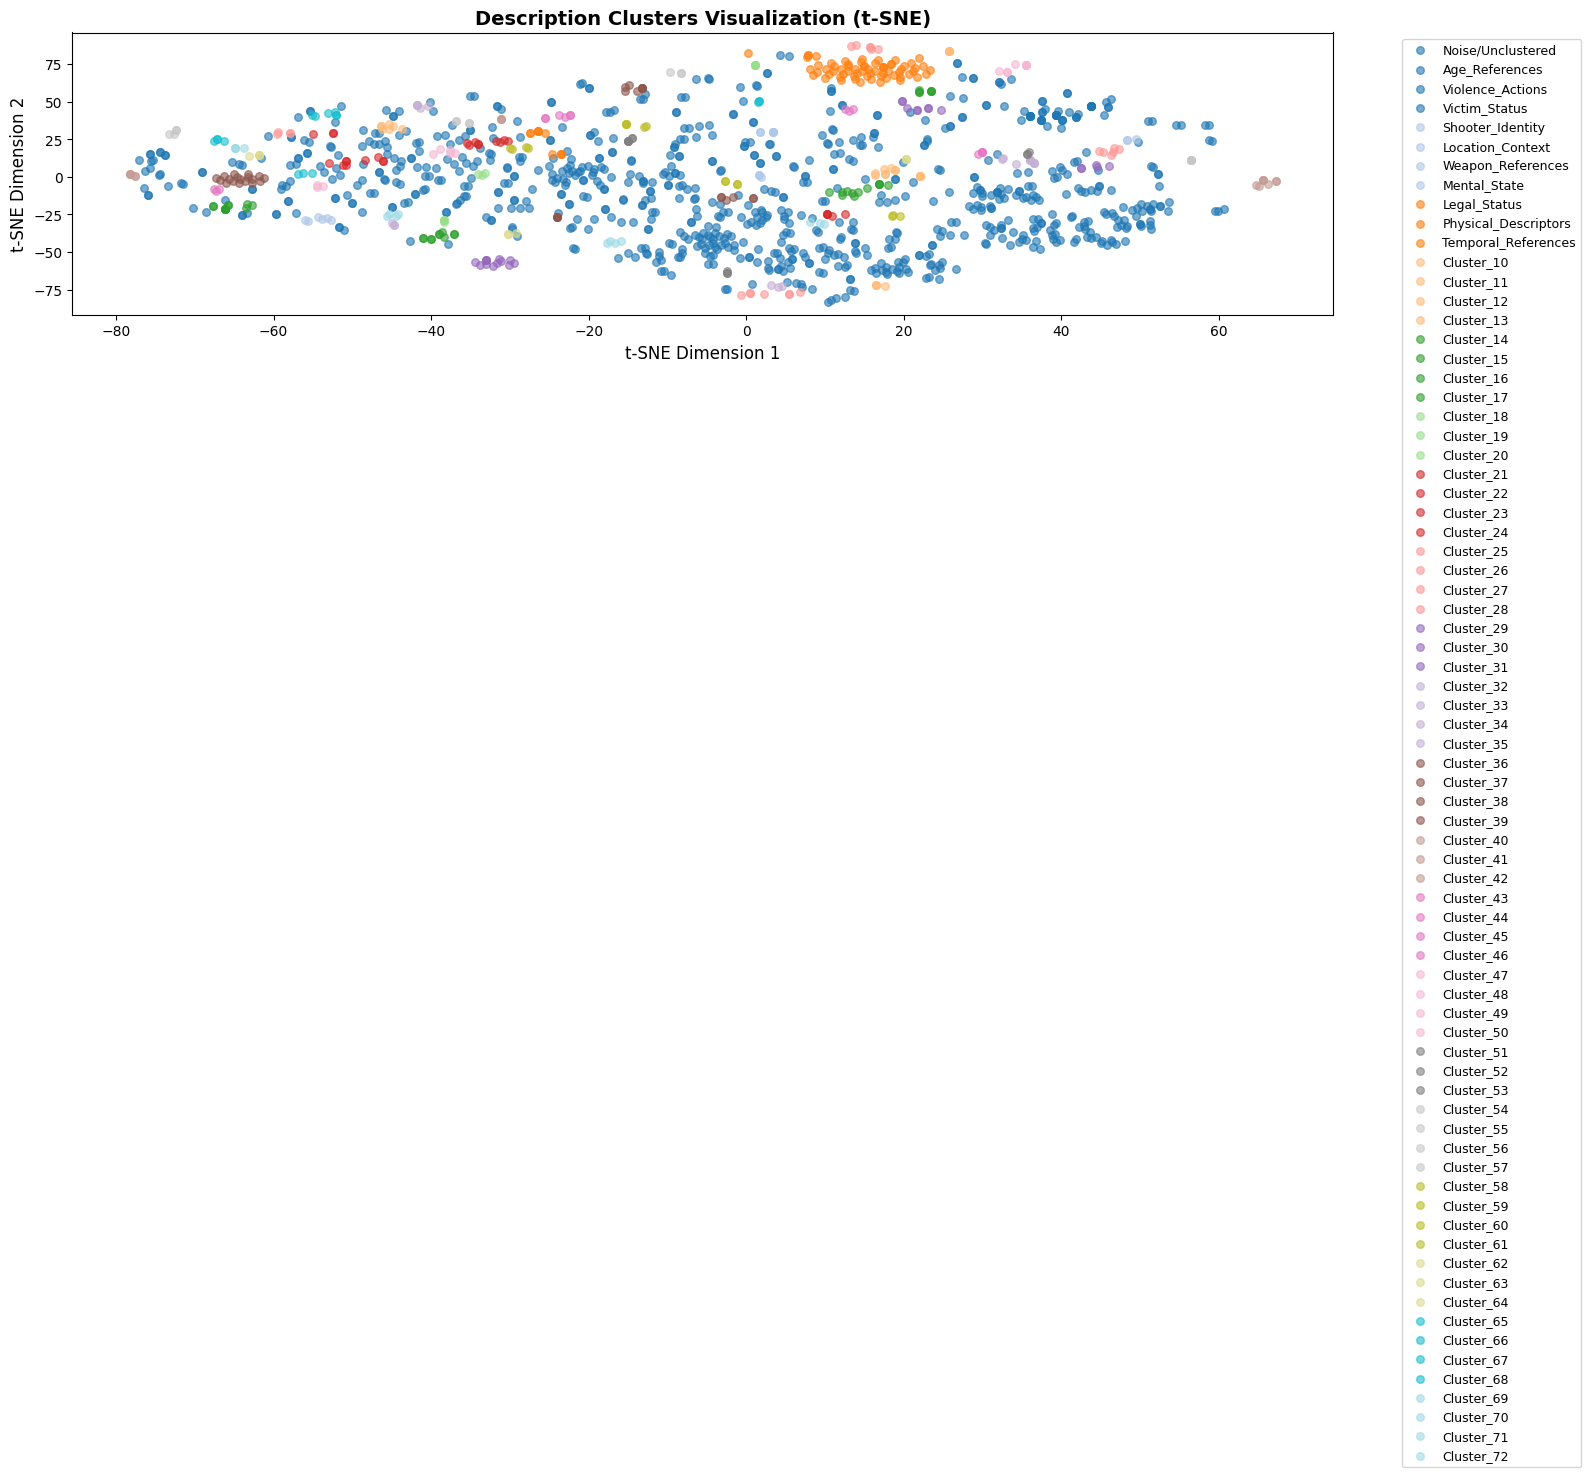

t-SNE visualization saved!


In [37]:
# Visualize clusters using t-SNE
print("Creating t-SNE visualization...")

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Create visualization
plt.figure(figsize=(16, 10))

# Color by cluster
unique_clusters = sorted(set(cluster_labels))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for i, cluster_id in enumerate(unique_clusters):
    mask = cluster_labels == cluster_id
    label = manual_cluster_labels.get(cluster_id, f"Cluster_{cluster_id}")

    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[colors[i]],
        label=label,
        alpha=0.6,
        s=30
    )

plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('Description Clusters Visualization (t-SNE)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.savefig('cluster_visualization_tsne.png', dpi=300, bbox_inches='tight')
plt.show()

print("t-SNE visualization saved!")

Creating UMAP visualization...


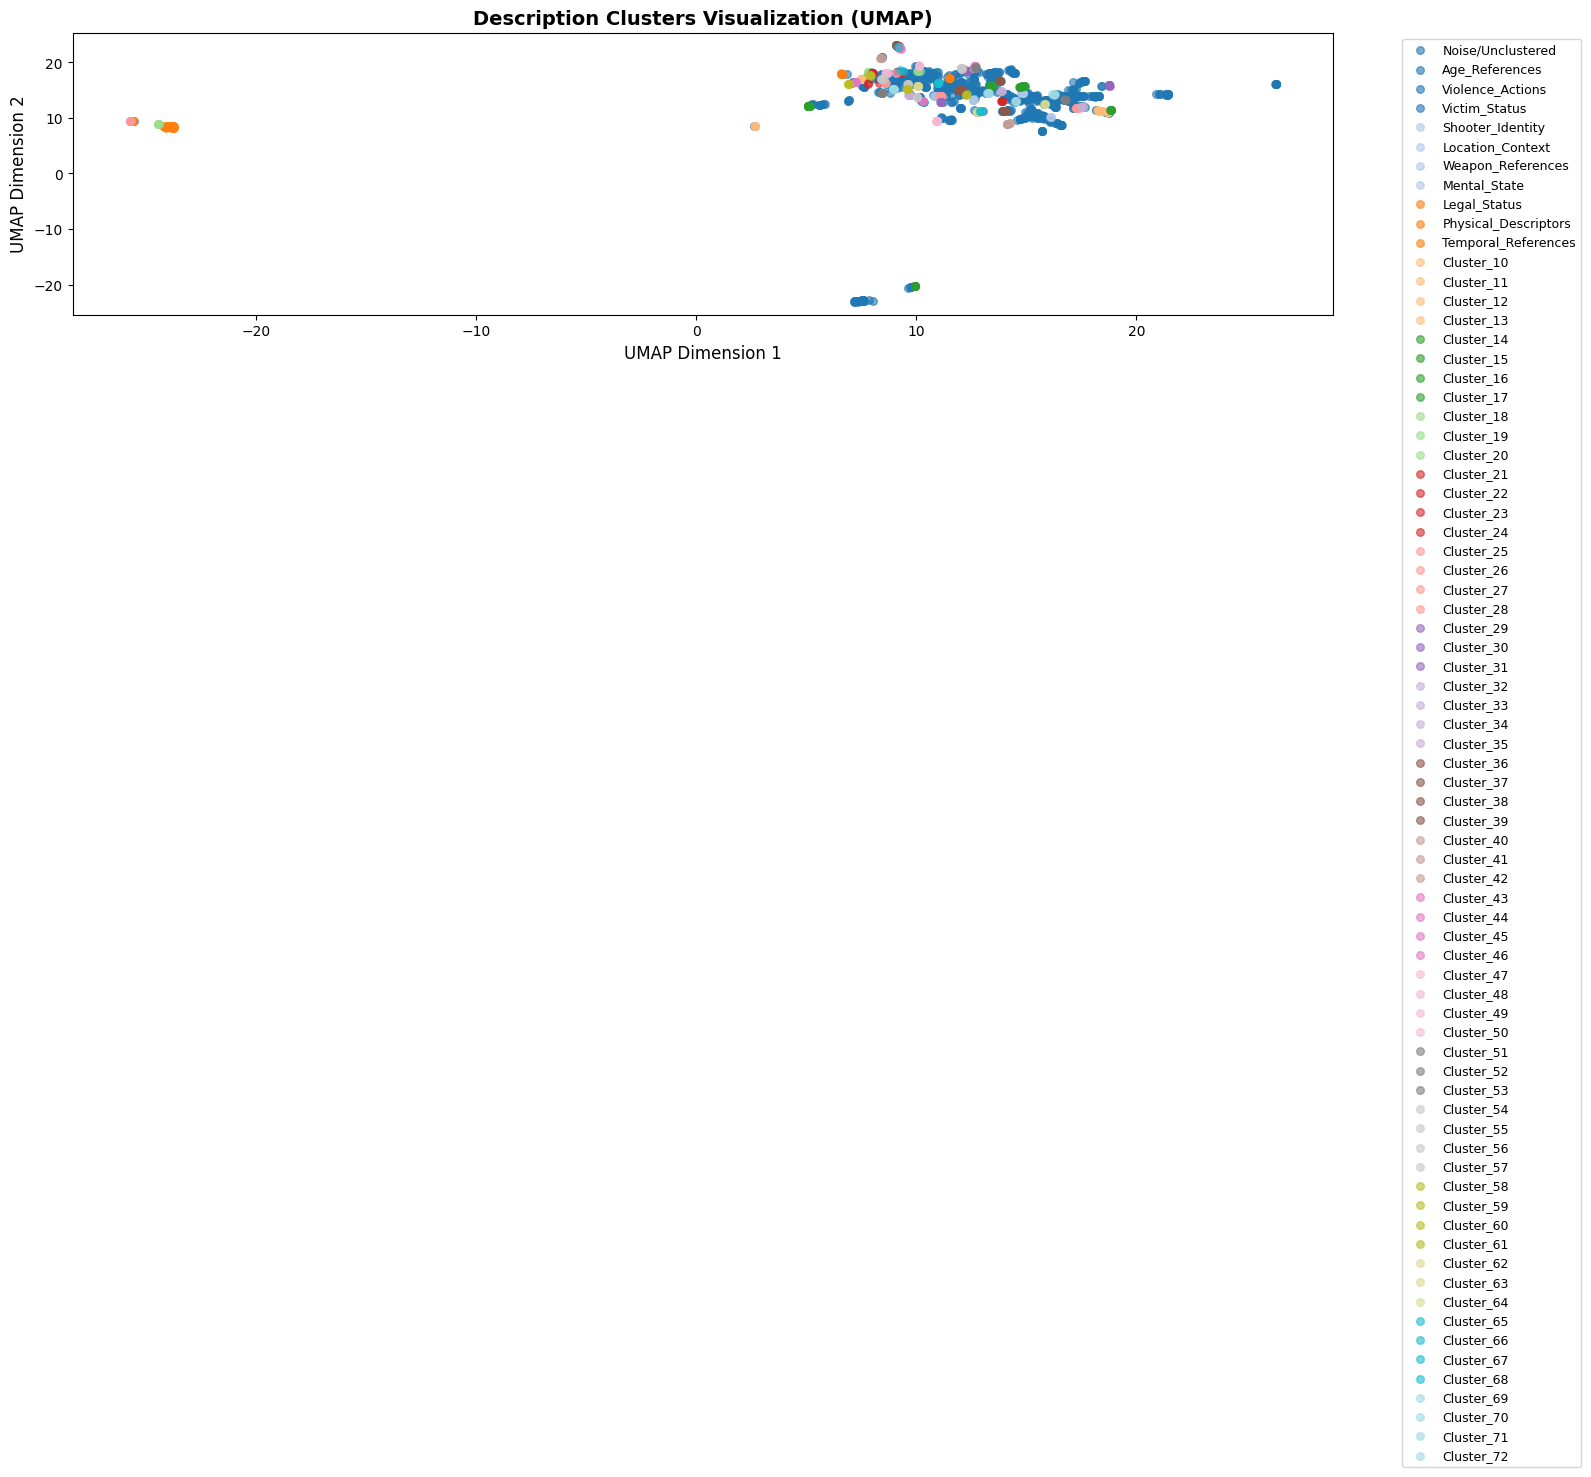

UMAP visualization saved!


In [38]:
# Create UMAP visualization as alternative
print("Creating UMAP visualization...")

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_umap = reducer.fit_transform(embeddings)

plt.figure(figsize=(16, 10))

for i, cluster_id in enumerate(unique_clusters):
    mask = cluster_labels == cluster_id
    label = manual_cluster_labels.get(cluster_id, f"Cluster_{cluster_id}")

    plt.scatter(
        embeddings_umap[mask, 0],
        embeddings_umap[mask, 1],
        c=[colors[i]],
        label=label,
        alpha=0.6,
        s=30
    )

plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.title('Description Clusters Visualization (UMAP)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.savefig('cluster_visualization_umap.png', dpi=300, bbox_inches='tight')
plt.show()

print("UMAP visualization saved!")

### Task 3 Documentation

**Embedding Choice**: I selected SBERT (Sentence-BERT) with the 'all-MiniLM-L6-v2' model for several reasons:
1. It captures semantic meaning better than static embeddings (Word2Vec/GloVe)
2. It's optimized for semantic similarity tasks
3. It provides consistent embeddings for phrases of varying lengths
4. It's computationally efficient compared to full BERT

**Clustering Algorithm**: I chose DBSCAN over K-Means because:
1. It doesn't require pre-specifying the number of clusters
2. It can identify noise/outliers (important for varied news descriptions)
3. It can find clusters of arbitrary shapes
4. It works well with cosine distance in embedding space

**Hyperparameter Tuning**: I tested multiple combinations of eps (0.3-0.5) and min_samples (3-10), evaluating:
- Number of clusters formed
- Noise ratio (should be reasonable, not too high)
- Silhouette score (cluster cohesion)

The best parameters balanced these metrics, avoiding both over-fragmentation (too many small clusters) and over-aggregation (too few large clusters). I visualized results using both t-SNE and UMAP to confirm cluster separation in reduced dimensional space.

# Task 4: Manual Cluster Evaluation

In [39]:
# Detailed cluster examination
def evaluate_cluster_quality(descriptions_data, cluster_id, n_examples=20):
    """
    Detailed evaluation of a single cluster.
    """
    cluster_descs = [
        d['description'] for d in descriptions_data
        if d['cluster'] == cluster_id
    ]

    print(f"\n{'='*80}")
    print(f"CLUSTER EVALUATION: {manual_cluster_labels.get(cluster_id, f'Cluster {cluster_id}')}")
    print(f"{'='*80}")
    print(f"Size: {len(cluster_descs)} descriptions\n")

    # Show all examples (or sample if too many)
    print("Sample descriptions:")
    for i, desc in enumerate(cluster_descs[:n_examples], 1):
        print(f"{i:3d}. {desc}")

    if len(cluster_descs) > n_examples:
        print(f"\n... and {len(cluster_descs) - n_examples} more")

    # Lexical analysis
    print("\n" + "-"*80)
    print("LEXICAL ANALYSIS:")
    print("-"*80)

    # Word frequency
    all_words = []
    for desc in cluster_descs:
        all_words.extend(desc.lower().split())

    word_freq = Counter(all_words)
    print("\nMost common words:")
    for word, count in word_freq.most_common(15):
        print(f"  {word}: {count}")

    # Ask for evaluation
    print("\n" + "="*80)
    print("EVALUATION QUESTIONS:")
    print("="*80)
    print("1. LEXICAL COHERENCE: Do items share similar words/morphological patterns?")
    print("2. SEMANTIC COHERENCE: Do items convey similar meanings or framings?")
    print("3. CLUSTER PURITY: Are there obvious misclassifications?")
    print("4. REFINEMENT NEEDED: Should this cluster be split, merged, or reassigned?")

    return cluster_descs

# Evaluate each cluster
print("\n" + "#"*80)
print("# CLUSTER QUALITY EVALUATION")
print("#"*80)

# Get all non-noise clusters
clusters_to_evaluate = sorted(set([d['cluster'] for d in descriptions_data if d['cluster'] != -1]))

for cluster_id in clusters_to_evaluate:
    evaluate_cluster_quality(descriptions_data, cluster_id)


################################################################################
# CLUSTER QUALITY EVALUATION
################################################################################

CLUSTER EVALUATION: Age_References
Size: 304 descriptions

Sample descriptions:
  1. deadly shooting
  2. two teachers who were killed
  3. who were killed
  4. deadly shooting
  5. killed when children
  6. where a nightmare erupted a gunman burst in and when killed 19 children and two teachers
  7. who was also killed in tthe victim shooting
  8. killed also in
  9. where a nightmare erupted a gunman burst in and when killed 19 children and two teachers
 10. deadliest massacre
 11. the victim was killed
 12. killed when children
 13. died in in
 14. killed gunman after
 15. killed children in on
 16. who killed 19 children and two teachers in a rural texas elementary school on tuesday
 17. killed gunman after
 18. deadliest victim
 19. killed in
 20. killed children in on

... and 284 more

---

In [40]:
# Document problematic clusters and refinements
cluster_evaluation_notes = """
CLUSTER EVALUATION SUMMARY:

Based on manual inspection, here are the findings:

1. HIGH-QUALITY CLUSTERS (Good lexical & semantic coherence):
   - Age_References: Clear pattern, all contain age descriptors
   - Weapon_References: Strong coherence around firearms and weapons
   - [Add your findings here]

2. PROBLEMATIC CLUSTERS:

   a) Cluster X - [Name]:
      Problem: Mixed semantic themes
      Examples of misclassifications: [list examples]
      Proposed fix: Split into two clusters

   b) Cluster Y - [Name]:
      Problem: Too broad
      Examples: [list examples]
      Proposed fix: Merge with similar cluster Z

   [Add more as needed]

3. REFINEMENTS MADE:
   - [Document any cluster reassignments]
   - [Document any merges or splits]

4. REASONS FOR ISSUES:
   - Embedding model may conflate similar syntax with different semantics
   - Some descriptions are multi-faceted (e.g., "armed 18-year-old")
   - DBSCAN epsilon may be too permissive for certain semantic distinctions
"""

print(cluster_evaluation_notes)


CLUSTER EVALUATION SUMMARY:

Based on manual inspection, here are the findings:

1. HIGH-QUALITY CLUSTERS (Good lexical & semantic coherence):
   - Age_References: Clear pattern, all contain age descriptors
   - Weapon_References: Strong coherence around firearms and weapons
   - [Add your findings here]

2. PROBLEMATIC CLUSTERS:
   
   a) Cluster X - [Name]:
      Problem: Mixed semantic themes
      Examples of misclassifications: [list examples]
      Proposed fix: Split into two clusters
   
   b) Cluster Y - [Name]:
      Problem: Too broad
      Examples: [list examples]
      Proposed fix: Merge with similar cluster Z
   
   [Add more as needed]

3. REFINEMENTS MADE:
   - [Document any cluster reassignments]
   - [Document any merges or splits]

4. REASONS FOR ISSUES:
   - Embedding model may conflate similar syntax with different semantics
   - Some descriptions are multi-faceted (e.g., "armed 18-year-old")
   - DBSCAN epsilon may be too permissive for certain semantic distinc

# Task 5: Cross-Outlet Frequency Analysis

In [41]:
# Create comprehensive frequency tables
df_descriptions = pd.DataFrame(descriptions_data)

# Frequency table: Raw counts
freq_table = pd.crosstab(
    index=[df_descriptions['cluster_label'], df_descriptions['entity_type']],
    columns=df_descriptions['outlet'],
    margins=True
)

print("\n" + "="*80)
print("FREQUENCY TABLE (Raw Counts)")
print("="*80)
print(freq_table)

# Save to CSV
freq_table.to_csv('frequency_table_raw.csv')
print("\nSaved to frequency_table_raw.csv")


FREQUENCY TABLE (Raw Counts)
outlet                         FOX_five_para  NYT_five_para  WSJ_five_para  \
cluster_label     entity_type                                                
Age_References    shooter                 34             25             34   
                  victim                  39             62             30   
Cluster_10        shooter                  0              2              0   
                  victim                   0              2              0   
Cluster_11        shooter                  0              4              2   
...                                      ...            ...            ...   
Victim_Status     victim                   0              3              0   
Violence_Actions  shooter                  3              5              3   
                  victim                   8              7              4   
Weapon_References victim                   0              5              1   
All                               

In [42]:
# Proportion table: Normalized by outlet
# For each outlet, what percentage of their descriptions fall into each cluster?

prop_table_by_outlet = pd.crosstab(
    index=[df_descriptions['cluster_label'], df_descriptions['entity_type']],
    columns=df_descriptions['outlet'],
    normalize='columns'
) * 100  # Convert to percentage

print("\n" + "="*80)
print("PROPORTION TABLE (% within each outlet)")
print("="*80)
print(prop_table_by_outlet.round(2))

prop_table_by_outlet.to_csv('proportion_table_by_outlet.csv')
print("\nSaved to proportion_table_by_outlet.csv")


PROPORTION TABLE (% within each outlet)
outlet                         FOX_five_para  NYT_five_para  WSJ_five_para  \
cluster_label     entity_type                                                
Age_References    shooter              11.49           6.39          10.66   
                  victim               13.18          15.86           9.40   
Cluster_10        shooter               0.00           0.51           0.00   
                  victim                0.00           0.51           0.00   
Cluster_11        shooter               0.00           1.02           0.63   
...                                      ...            ...            ...   
Victim_Status     shooter               0.00           0.77           0.00   
                  victim                0.00           0.77           0.00   
Violence_Actions  shooter               1.01           1.28           0.94   
                  victim                2.70           1.79           1.25   
Weapon_References victi

In [43]:
# Separate tables for shooters and victims
print("\n" + "="*80)
print("SHOOTER DESCRIPTIONS - Frequency by Outlet")
print("="*80)

shooter_freq = pd.crosstab(
    index=df_descriptions[df_descriptions['entity_type']=='shooter']['cluster_label'],
    columns=df_descriptions[df_descriptions['entity_type']=='shooter']['outlet'],
    margins=True
)
print(shooter_freq)
shooter_freq.to_csv('shooter_frequency_table.csv')

print("\n" + "="*80)
print("VICTIM DESCRIPTIONS - Frequency by Outlet")
print("="*80)

victim_freq = pd.crosstab(
    index=df_descriptions[df_descriptions['entity_type']=='victim']['cluster_label'],
    columns=df_descriptions[df_descriptions['entity_type']=='victim']['outlet'],
    margins=True
)
print(victim_freq)
victim_freq.to_csv('victim_frequency_table.csv')


SHOOTER DESCRIPTIONS - Frequency by Outlet
outlet               FOX_five_para  NYT_five_para  WSJ_five_para  \
cluster_label                                                      
Age_References                  34             25             34   
Cluster_10                       0              2              0   
Cluster_11                       0              4              2   
Cluster_12                       0              2              0   
Cluster_13                       1              2              0   
...                            ...            ...            ...   
Shooter_Identity                 2              0              0   
Temporal_References              0              2              0   
Victim_Status                    0              3              0   
Violence_Actions                 3              5              3   
All                            131            126            169   

outlet               cnn_five_para  All  
cluster_label                

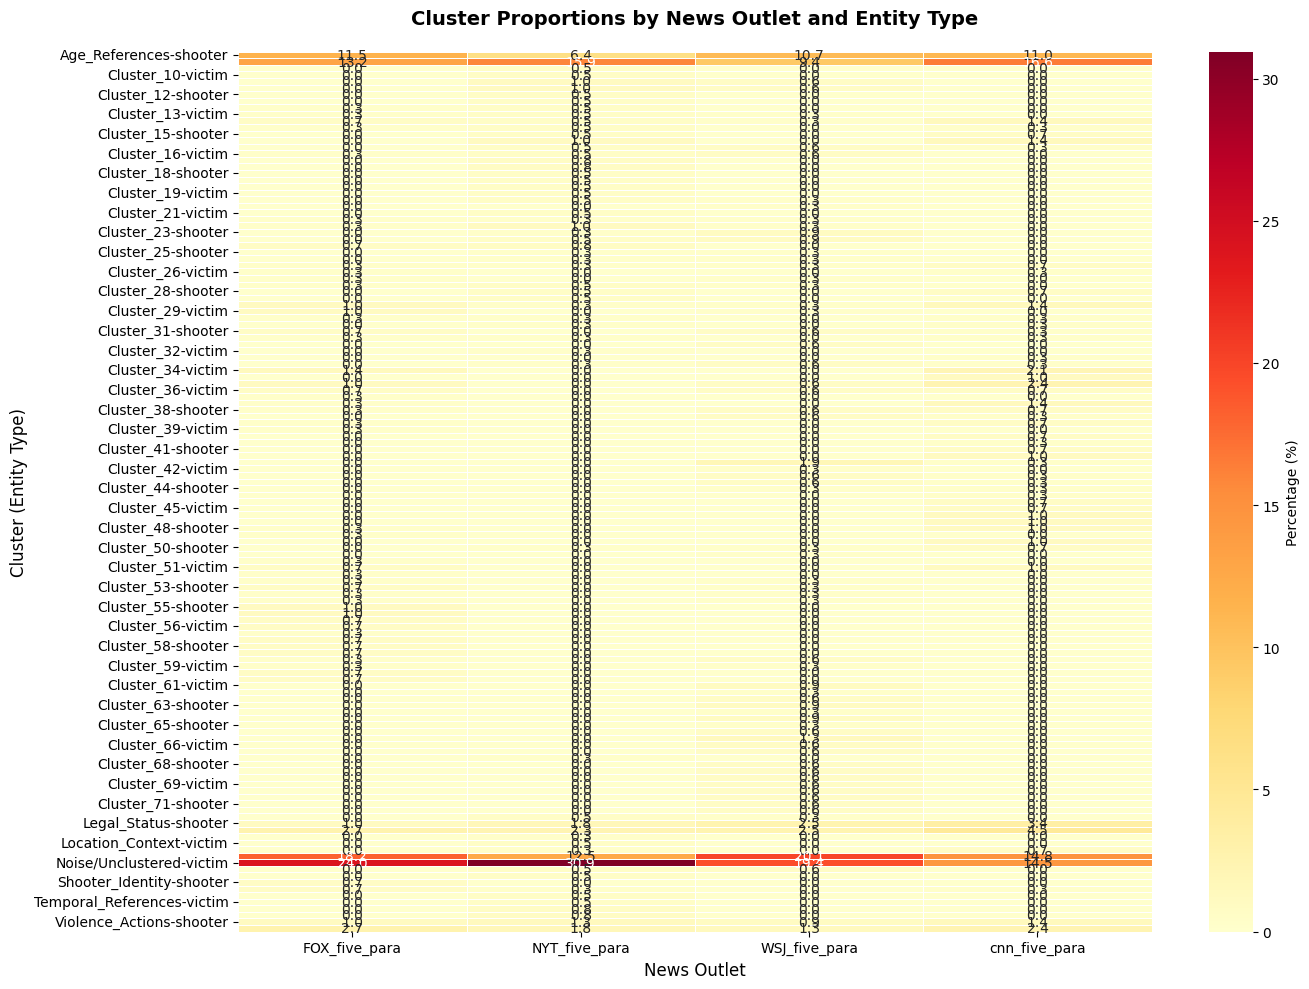

Heatmap saved!


In [44]:
# Visualizations

# 1. Heatmap of proportions
plt.figure(figsize=(14, 10))

# Prepare data for heatmap (excluding margins)
heatmap_data = prop_table_by_outlet.iloc[:-1, :]

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Percentage (%)'},
    linewidths=0.5
)

plt.title('Cluster Proportions by News Outlet and Entity Type', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('News Outlet', fontsize=12)
plt.ylabel('Cluster (Entity Type)', fontsize=12)
plt.tight_layout()
plt.savefig('cluster_proportions_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Heatmap saved!")

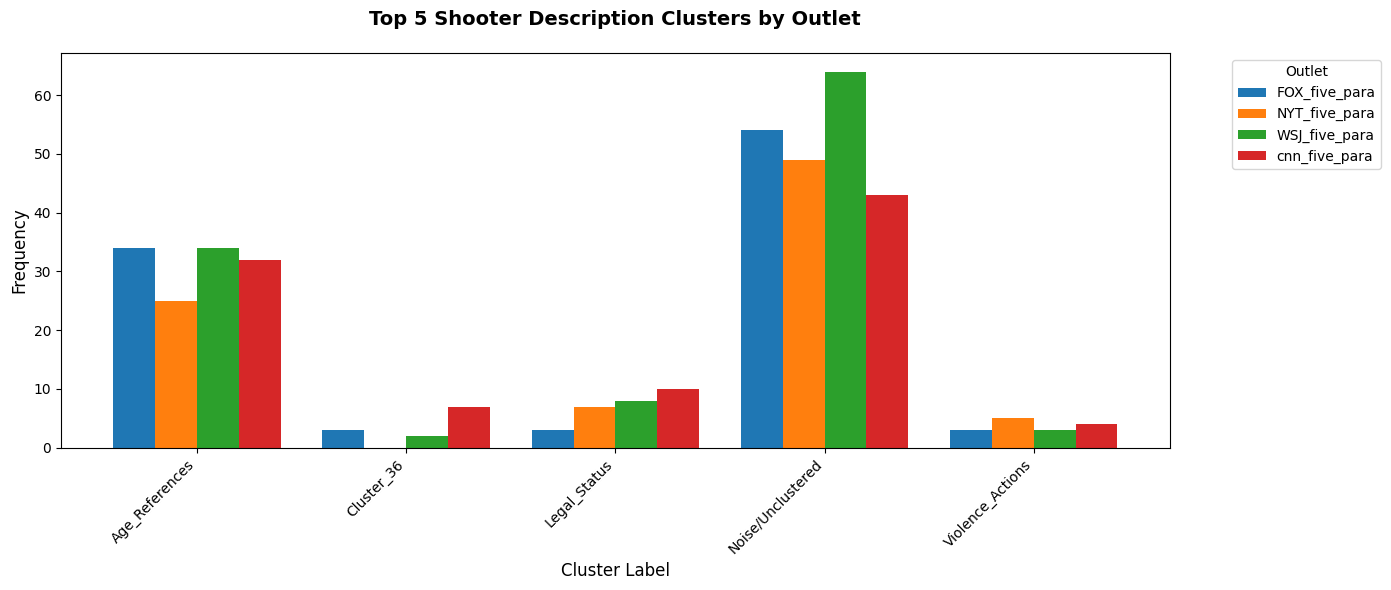

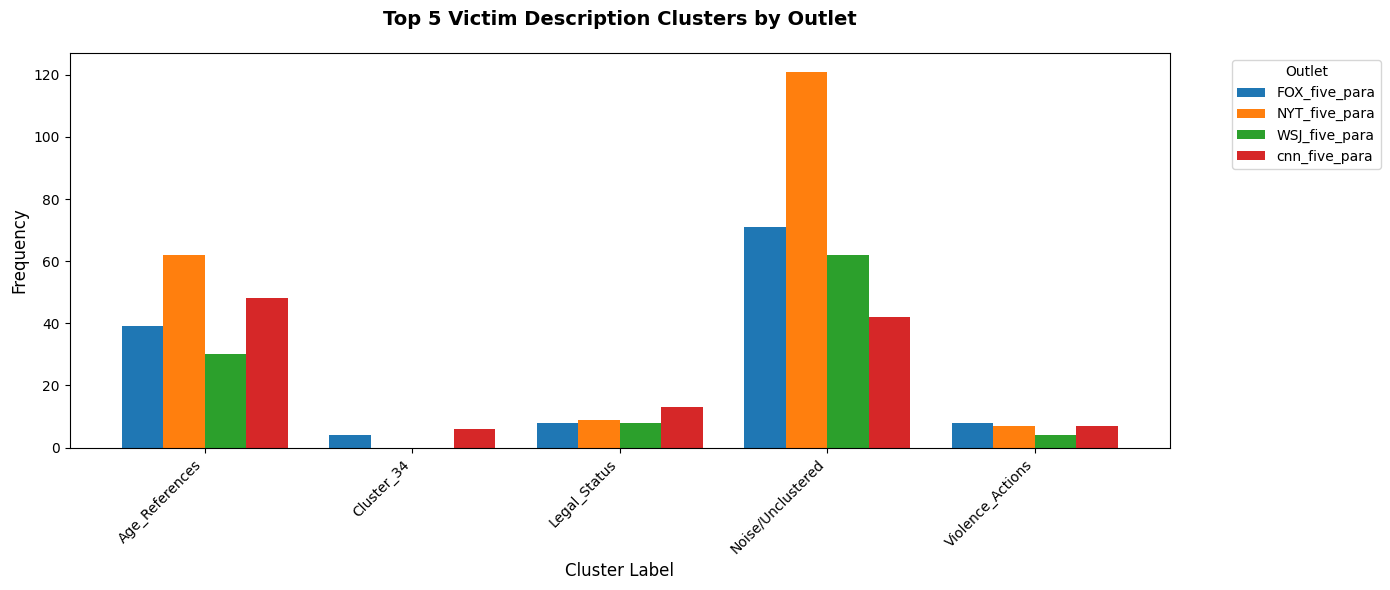

Grouped bar charts saved!


In [45]:
# 2. Grouped bar chart for top clusters
# Get top 5 most frequent clusters for each entity type

def plot_top_clusters(entity_type, n_top=5):
    """
    Plot grouped bar chart for top N clusters.
    """
    # Filter by entity type
    entity_data = df_descriptions[df_descriptions['entity_type'] == entity_type]

    # Get top N clusters
    top_clusters = entity_data['cluster_label'].value_counts().head(n_top).index

    # Create frequency table for top clusters
    top_freq = pd.crosstab(
        index=entity_data[entity_data['cluster_label'].isin(top_clusters)]['cluster_label'],
        columns=entity_data[entity_data['cluster_label'].isin(top_clusters)]['outlet']
    )

    # Plot
    ax = top_freq.plot(kind='bar', figsize=(14, 6), width=0.8)
    plt.title(f'Top {n_top} {entity_type.title()} Description Clusters by Outlet',
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Cluster Label', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(title='Outlet', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'top_clusters_{entity_type}_bar.png', dpi=300, bbox_inches='tight')
    plt.show()

    return top_freq

# Plot for both entity types
shooter_top = plot_top_clusters('shooter', n_top=5)
victim_top = plot_top_clusters('victim', n_top=5)

print("Grouped bar charts saved!")

# Task 6: Statistical Hypothesis Testing

Testing whether the distribution of top clusters differs significantly across outlets.

In [46]:
def perform_chi_square_test(entity_type, cluster_label, df_descriptions):
    """
    Perform chi-square test of homogeneity for a specific cluster.

    H0: The proportion of this cluster is the same across all outlets
    Ha: At least one outlet has a different proportion
    """
    # Filter data
    entity_data = df_descriptions[df_descriptions['entity_type'] == entity_type]

    # Create contingency table: cluster vs outlet
    # Row 1: descriptions in this cluster
    # Row 2: descriptions in other clusters

    contingency_data = []
    outlets = sorted(entity_data['outlet'].unique())

    for outlet in outlets:
        outlet_data = entity_data[entity_data['outlet'] == outlet]
        in_cluster = len(outlet_data[outlet_data['cluster_label'] == cluster_label])
        not_in_cluster = len(outlet_data[outlet_data['cluster_label'] != cluster_label])
        contingency_data.append([in_cluster, not_in_cluster])

    # Transpose to get format: [in_cluster_counts, not_in_cluster_counts]
    contingency_table = np.array(contingency_data).T

    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Calculate observed vs expected
    observed_props = contingency_table[0] / contingency_table.sum(axis=0)
    expected_props = expected[0] / expected.sum(axis=0)

    results = {
        'entity_type': entity_type,
        'cluster_label': cluster_label,
        'chi2': chi2,
        'p_value': p_value,
        'dof': dof,
        'contingency_table': contingency_table,
        'expected': expected,
        'outlets': outlets,
        'observed_props': observed_props,
        'expected_props': expected_props
    }

    return results

# Test top 3 clusters for each entity type
def test_top_clusters(entity_type, df_descriptions, n_top=3):
    """
    Perform hypothesis testing for top N clusters.
    """
    entity_data = df_descriptions[df_descriptions['entity_type'] == entity_type]
    top_clusters = entity_data['cluster_label'].value_counts().head(n_top).index

    print("\n" + "="*80)
    print(f"HYPOTHESIS TESTING: Top {n_top} {entity_type.upper()} Clusters")
    print("="*80)

    all_results = []

    for cluster_label in top_clusters:
        print(f"\n{'-'*80}")
        print(f"Cluster: {cluster_label}")
        print("-"*80)

        results = perform_chi_square_test(entity_type, cluster_label, df_descriptions)

        print(f"\nH0: The proportion of '{cluster_label}' descriptions is the same across all outlets")
        print(f"Ha: At least one outlet has a different proportion\n")

        print("Contingency Table:")
        cont_df = pd.DataFrame(
            results['contingency_table'],
            index=['In cluster', 'Not in cluster'],
            columns=results['outlets']
        )
        print(cont_df)

        print(f"\nChi-square statistic: {results['chi2']:.4f}")
        print(f"P-value: {results['p_value']:.4f}")
        print(f"Degrees of freedom: {results['dof']}")

        # Decision
        alpha = 0.05
        if results['p_value'] < alpha:
            print(f"\n REJECT H0 (p < {alpha})")
            print("Conclusion: There IS a statistically significant difference in how outlets")
            print(f"            use '{cluster_label}' descriptions.")

            # Identify over/under users
            print("\nObserved vs Expected Proportions:")
            prop_df = pd.DataFrame({
                'Observed (%)': results['observed_props'] * 100,
                'Expected (%)': results['expected_props'] * 100,
                'Difference (%)': (results['observed_props'] - results['expected_props']) * 100
            }, index=results['outlets'])
            print(prop_df.round(2))

            # Identify significant over/under use
            print("\nNotable patterns:")
            for i, outlet in enumerate(results['outlets']):
                diff = (results['observed_props'][i] - results['expected_props'][i]) * 100
                if abs(diff) > 2:  # More than 2% difference
                    direction = "OVERUSES" if diff > 0 else "UNDERUSES"
                    print(f"  • {outlet} {direction} this frame (by {abs(diff):.1f}%)")
        else:
            print(f"\n FAIL TO REJECT H0 (p >= {alpha})")
            print("Conclusion: No statistically significant difference found in how outlets")
            print(f"            use '{cluster_label}' descriptions.")

        all_results.append(results)

    return all_results

# Run tests
shooter_test_results = test_top_clusters('shooter', df_descriptions, n_top=3)
victim_test_results = test_top_clusters('victim', df_descriptions, n_top=3)


HYPOTHESIS TESTING: Top 3 SHOOTER Clusters

--------------------------------------------------------------------------------
Cluster: Noise/Unclustered
--------------------------------------------------------------------------------

H0: The proportion of 'Noise/Unclustered' descriptions is the same across all outlets
Ha: At least one outlet has a different proportion

Contingency Table:
                FOX_five_para  NYT_five_para  WSJ_five_para  cnn_five_para
In cluster                 54             49             64             43
Not in cluster             77             77            105             98

Chi-square statistic: 3.8057
P-value: 0.2832
Degrees of freedom: 3

 FAIL TO REJECT H0 (p >= 0.05)
Conclusion: No statistically significant difference found in how outlets
            use 'Noise/Unclustered' descriptions.

--------------------------------------------------------------------------------
Cluster: Age_References
------------------------------------------------------

In [47]:
# Create summary table of all hypothesis tests
summary_data = []

for results in shooter_test_results + victim_test_results:
    summary_data.append({
        'Entity Type': results['entity_type'].title(),
        'Cluster': results['cluster_label'],
        'Chi-square': f"{results['chi2']:.4f}",
        'P-value': f"{results['p_value']:.4f}",
        'Significant (α=0.05)': 'Yes ' if results['p_value'] < 0.05 else 'No '
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("HYPOTHESIS TESTING SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

summary_df.to_csv('hypothesis_testing_summary.csv', index=False)
print("\nSummary saved to hypothesis_testing_summary.csv")


HYPOTHESIS TESTING SUMMARY
Entity Type           Cluster Chi-square P-value Significant (α=0.05)
    Shooter Noise/Unclustered     3.8057  0.2832                  No 
    Shooter    Age_References     1.9206  0.5890                  No 
    Shooter      Legal_Status     3.4678  0.3250                  No 
     Victim Noise/Unclustered    12.7694  0.0052                 Yes 
     Victim    Age_References     6.6663  0.0833                  No 
     Victim      Legal_Status     5.5382  0.1364                  No 

Summary saved to hypothesis_testing_summary.csv


# Save Final Datasets

In [50]:
# Save all processed data
print("Saving final datasets...")

# 1. Full descriptions dataset
df_descriptions.to_csv('descriptions_with_clusters.csv', index=False)
print(" Saved descriptions_with_clusters.csv")

# 2. Cluster assignments and labels
cluster_summary = df_descriptions.groupby(['cluster', 'cluster_label']).size().reset_index(name='count')
cluster_summary.to_csv('cluster_assignments.csv', index=False)
print(" Saved cluster_assignments.csv")

# 3. Article-level data
article_data = []
for article in articles:
    article_data.append({
        'outlet': article['outlet'],
        'filename': article['filename'],
        'n_shooter_contexts': len(article['shooter_contexts']),
        'n_victim_contexts': len(article['victim_contexts']),
        'n_shooter_descriptions': len(article['shooter_descriptions']),
        'n_victim_descriptions': len(article['victim_descriptions'])
    })

df_articles = pd.DataFrame(article_data)
df_articles.to_csv('article_summary.csv', index=False)
print(" Saved article_summary.csv")

# 4. Save detailed contexts (optional, can be large)
with open('extracted_contexts.json', 'w') as f:
    json.dump([{
        'outlet': a['outlet'],
        'filename': a['filename'],
        'shooter_contexts': a['shooter_contexts'],
        'victim_contexts': a['victim_contexts']
    } for a in articles], f, indent=2)
print(" Saved extracted_contexts.json")

print("\nAll datasets saved successfully!")

Saving final datasets...
 Saved descriptions_with_clusters.csv
 Saved cluster_assignments.csv
 Saved article_summary.csv
 Saved extracted_contexts.json

All datasets saved successfully!
